In [1]:
import pandas as pd
import joblib
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [2]:
# Load the trained model
model_path = "../models/lgbm_model_top30.pkl"
lgb_model_top30 = joblib.load(model_path)

print("Model successfully loaded!")

Model successfully loaded!


In [3]:
# Load the cleaned dataset from Parquet
data_path = "../data/processed/day0_data_cleaned_finalcode.parquet"
day0_data_cleaned = pd.read_parquet(data_path)

# Define features (X) and target (y)
X = day0_data_cleaned.drop(columns=["responder_6"])  # Drop the target column
y = day0_data_cleaned["responder_6"]  # Target variable

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")

Training Features Shape: (1555368, 56)
Testing Features Shape: (388842, 56)


In [4]:
# Ensure model is trained
if "lgb_model_top30" not in globals():
    raise ValueError("The LightGBM model (lgb_model_top30) is not defined. Train or load it first.")

# Extract feature names and importance from the trained model
trained_feature_names = lgb_model_top30.feature_name_  
trained_importances = lgb_model_top30.feature_importances_

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': trained_feature_names,
    'Importance': trained_importances
})

# Filter features that exist in X_train
feature_importance = feature_importance[feature_importance["Feature"].isin(X_train.columns)]

# Sort by importance (descending order)
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Extract the **top 30** most important features
top_30_features = feature_importance.head(30)["Feature"].tolist()

print(f"Top 30 Features: {top_30_features}")

Top 30 Features: ['feature_62', 'feature_20', 'feature_25', 'feature_70', 'feature_28', 'feature_22', 'feature_61', 'feature_30', 'feature_38', 'feature_23', 'feature_47', 'feature_08', 'feature_63', 'feature_05', 'feature_49', 'feature_69', 'feature_33', 'feature_39', 'feature_42', 'feature_58', 'feature_72', 'feature_50', 'feature_78', 'feature_53', 'feature_44', 'feature_60', 'feature_45', 'feature_46', 'feature_07', 'feature_36']


In [5]:
# Select only the top 30 features from the dataset
X_train_top30 = X_train[top_30_features]
X_test_top30 = X_test[top_30_features]

print(f"Using {X_train_top30.shape[1]} features for SHAP analysis")

Using 30 features for SHAP analysis


In [6]:
import shap
import numpy as np
from tqdm import tqdm  # Import tqdm for real-time progress tracking

# Create a SHAP explainer for LightGBM
explainer = shap.TreeExplainer(lgb_model_top30)

# Initialize an empty array to store SHAP values
shap_values = np.zeros((len(X_test_top30), X_test_top30.shape[1]))

print("Calculating SHAP values...")

# Compute SHAP values with a progress bar
for i in tqdm(range(len(X_test_top30)), desc="SHAP Progress", unit="sample"):
    shap_values[i] = explainer.shap_values(X_test_top30.iloc[i:i+1])[0]

print("\nSHAP values calculation completed!")

Calculating SHAP values...


SHAP Progress: 100%|██████████| 388842/388842 [1:34:59<00:00, 68.22sample/s]  


SHAP values calculation completed!


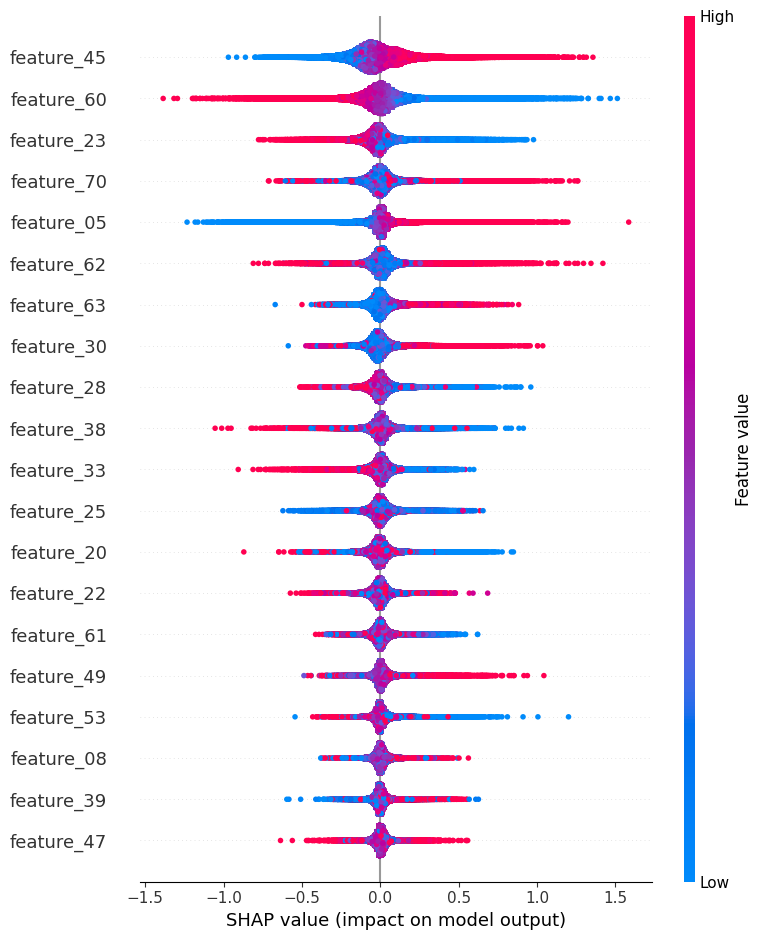

In [7]:
import matplotlib.pyplot as plt

# Create SHAP summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_top30)

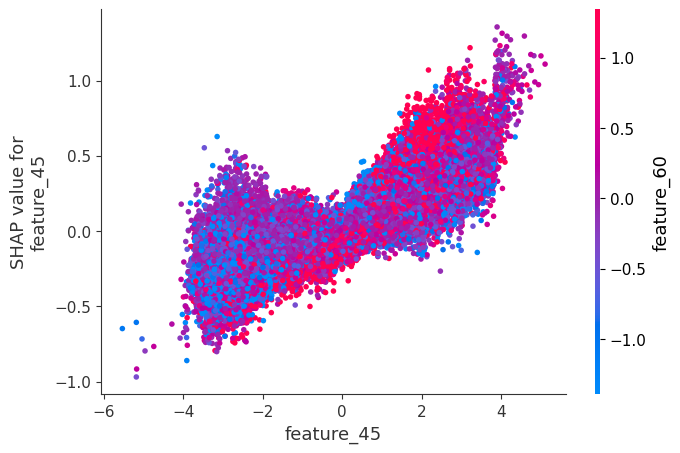

In [8]:
# Identfiying non-linear relationships

# Select a feature from the top 30 
shap.dependence_plot("feature_45", shap_values, X_test_top30)

In [14]:
# the curved relationship inidicated a non linear effect and the colours indicate a high correlation with feature 60

# log transformation for positive values

X_train["feature_45_log"] = np.where(X_train["feature_45"] > 0, 
                                     np.log1p(X_train["feature_45"]), 
                                     X_train["feature_45"])

X_test["feature_45_log"] = np.where(X_test["feature_45"] > 0, 
                                    np.log1p(X_test["feature_45"]), 
                                    X_test["feature_45"])

In [15]:
# verifying the transformation

print(X_train["feature_45_log"].describe())  # Summary statistics
print(X_test["feature_45_log"].describe())

# Check for NaN values
print("NaN values in training data:", X_train["feature_45_log"].isna().sum())
print("NaN values in test data:", X_test["feature_45_log"].isna().sum())

count    1.555368e+06
mean    -4.853812e-01
std      1.115054e+00
min     -5.539638e+00
25%     -1.294306e+00
50%     -2.893619e-01
75%      4.332489e-01
max      1.828268e+00
Name: feature_45_log, dtype: float64
count    388842.000000
mean         -0.486895
std           1.115770
min          -5.539638
25%          -1.297914
50%          -0.291068
75%           0.435182
max           1.809951
Name: feature_45_log, dtype: float64
NaN values in training data: 0
NaN values in test data: 0


In [16]:
# Drop the original feature_45 and add the transformed version
X_train_transformed = X_train.drop(columns=["feature_45"]).copy()
X_train_transformed["feature_45_log"] = X_train["feature_45_log"]

X_test_transformed = X_test.drop(columns=["feature_45"]).copy()
X_test_transformed["feature_45_log"] = X_test["feature_45_log"]

print(f"New Training Shape: {X_train_transformed.shape}")
print(f"New Testing Shape: {X_test_transformed.shape}")

New Training Shape: (1555368, 56)
New Testing Shape: (388842, 56)


In [17]:
lgb_model_transformed = lgb.LGBMRegressor(
    subsample=1.0,
    num_leaves=70,
    n_estimators=1000,
    min_child_samples=30,
    max_depth=15,
    learning_rate=0.3,
    random_state=42
)

print("Training LightGBM with transformed feature...")
lgb_model_transformed.fit(X_train_transformed, y_train)

print("Model retrained!")

Training LightGBM with transformed feature...


Python(94251) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13143
[LightGBM] [Info] Number of data points in the train set: 1555368, number of used features: 56
[LightGBM] [Info] Start training from score 0.001706
Model retrained!


In [18]:
y_pred_transformed = lgb_model_transformed.predict(X_test_transformed)

# Compute evaluation metrics
mse_transformed = mean_squared_error(y_test, y_pred_transformed)
rmse_transformed = np.sqrt(mse_transformed)
mae_transformed = mean_absolute_error(y_test, y_pred_transformed)
r2_transformed = r2_score(y_test, y_pred_transformed)

# Print results
print(f"Updated Model Performance:")
print(f"Test MSE: {mse_transformed}")
print(f"Test RMSE: {rmse_transformed}")
print(f"Test MAE: {mae_transformed}")
print(f"Test R²: {r2_transformed}")

Updated Model Performance:
Test MSE: 0.3802617315273541
Test RMSE: 0.6166536560560993
Test MAE: 0.4310924704021106
Test R²: 0.4992791777820892


In [ ]:
# transforming the feature 45 improved the model

In [22]:
# Create Interaction Feature

# Create an interaction feature between feature_45_log and feature_60
X_train["feature_45_60_interaction"] = X_train["feature_45_log"] * X_train["feature_60"]
X_test["feature_45_60_interaction"] = X_test["feature_45_log"] * X_test["feature_60"]

print("Interaction feature created successfully!")

# Drop the original feature_45 (since we now use feature_45_log)
X_train = X_train.drop(columns=["feature_45"])
X_test = X_test.drop(columns=["feature_45"])

print("Original feature_45 dropped successfully!")

# Retrain LightGBM with the new feature
lgb_model_interaction = lgb.LGBMRegressor(
    subsample=1.0,
    num_leaves=70,
    n_estimators=1000,
    min_child_samples=30,
    max_depth=15,
    learning_rate=0.3,
    random_state=42
)

# Fit the model with the updated feature set
lgb_model_interaction.fit(X_train, y_train)

print("Model retrained with interaction feature!")

# Predict on test set
y_pred_interaction = lgb_model_interaction.predict(X_test)

# Compute performance metrics
mse_interaction = mean_squared_error(y_test, y_pred_interaction)
rmse_interaction = np.sqrt(mse_interaction)
mae_interaction = mean_absolute_error(y_test, y_pred_interaction)
r2_interaction = r2_score(y_test, y_pred_interaction)

# Print evaluation results
print(f"New Model with Interaction Feature - Test MSE: {mse_interaction}")
print(f"New Model with Interaction Feature - Test RMSE: {rmse_interaction}")
print(f"New Model with Interaction Feature - Test MAE: {mae_interaction}")
print(f"New Model with Interaction Feature - Test R²: {r2_interaction}")

Interaction feature created successfully!
Original feature_45 dropped successfully!
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13398
[LightGBM] [Info] Number of data points in the train set: 1555368, number of used features: 57
[LightGBM] [Info] Start training from score 0.001706
Model retrained with interaction feature!
New Model with Interaction Feature - Test MSE: 0.38343177823650754
New Model with Interaction Feature - Test RMSE: 0.6192186836946278
New Model with Interaction Feature - Test MAE: 0.43286518491868153
New Model with Interaction Feature - Test R²: 0.495104925515628


In [23]:
# the interaction feature decreases the perfomance. It will not be used in the further analysis

# Drop the interaction feature (since it reduced performance)
X_train = X_train.drop(columns=["feature_45_60_interaction"], errors="ignore")
X_test = X_test.drop(columns=["feature_45_60_interaction"], errors="ignore")

print("Removed interaction feature. Now re-training the model...")

Removed interaction feature. Now re-training the model...


Generating SHAP dependence plot for feature_60...


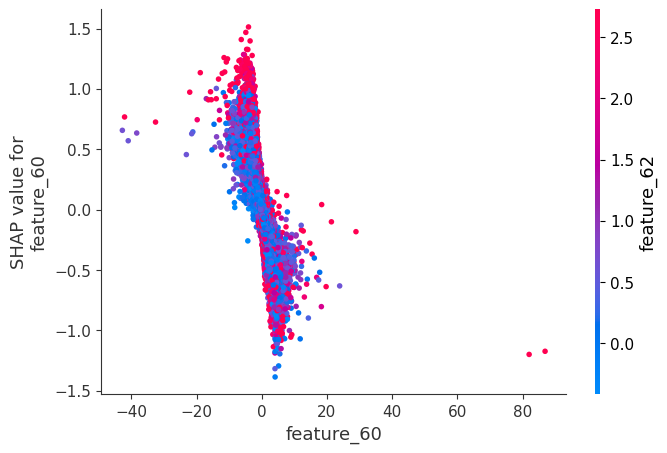

Generating SHAP dependence plot for feature_23...


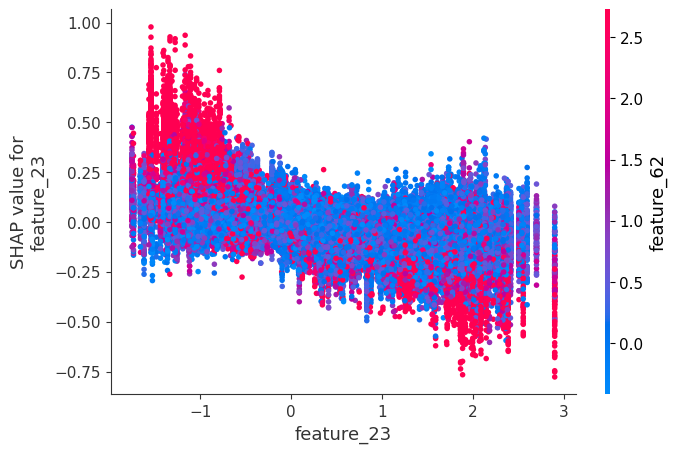

Generating SHAP dependence plot for feature_70...


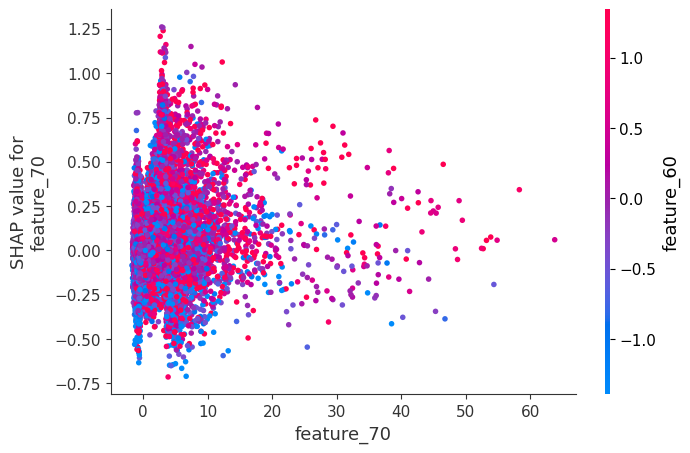

Generating SHAP dependence plot for feature_05...


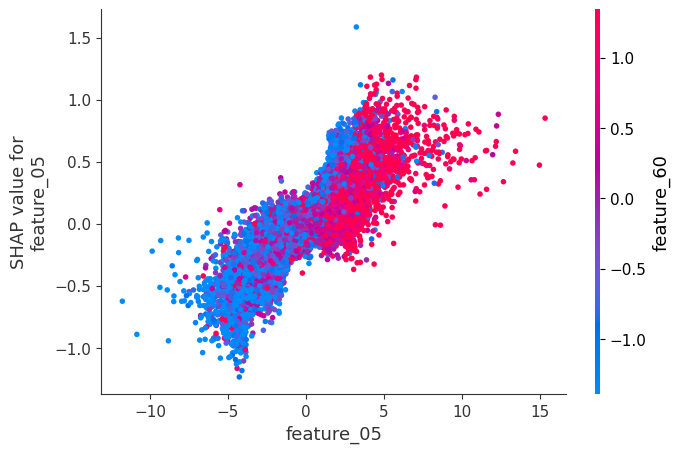

Generating SHAP dependence plot for feature_62...


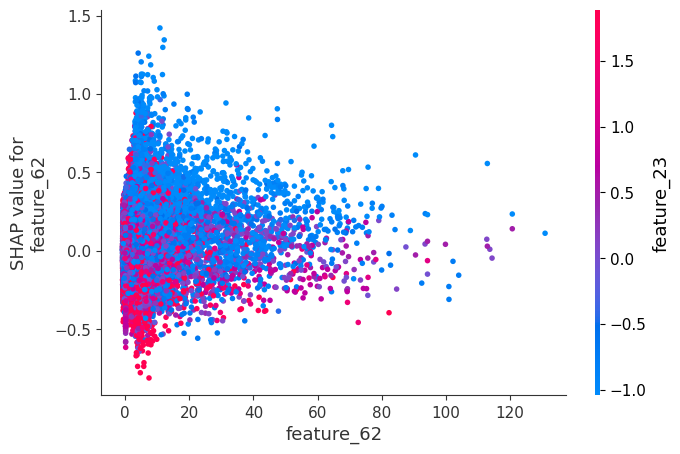

In [25]:
# Finding more non-linear features

import shap

# List of selected features to analyze
selected_features = ["feature_60", "feature_23", "feature_70", "feature_05", "feature_62"]

# Generate SHAP dependence plots for the selected features
for feature in selected_features:
    print(f"Generating SHAP dependence plot for {feature}...")
    shap.dependence_plot(feature, shap_values, X_test_top30)

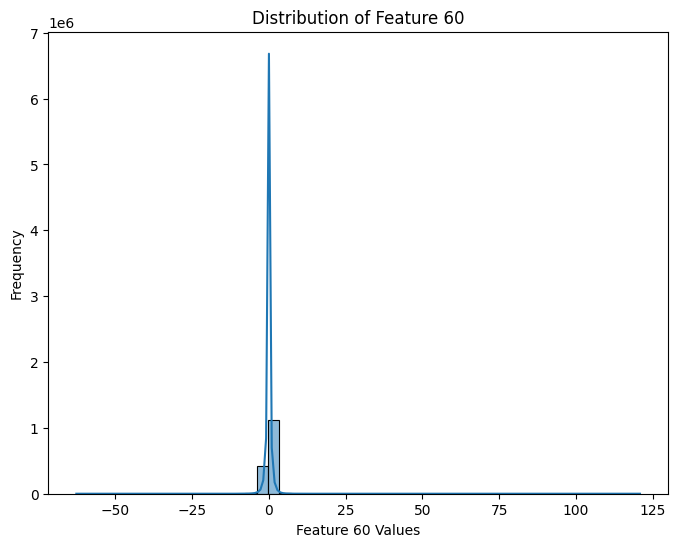

In [26]:
# Improving feature 60 and its contribution to the model

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of Feature 60
plt.figure(figsize=(8, 6))
sns.histplot(X_train["feature_60"], bins=50, kde=True)
plt.xlabel("Feature 60 Values")
plt.ylabel("Frequency")
plt.title("Distribution of Feature 60")
plt.show()

In [27]:
# checking for neagtives values

negative_values = (X_train["feature_60"] < 0).sum()
print(f"Number of negative values in Feature 60: {negative_values}")

Number of negative values in Feature 60: 811621


In [28]:
# Doing a Yeo-Johnson Transformation instead of a log transformation because it can handle both positive and negative values

from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize transformer
yeo_johnson = PowerTransformer(method='yeo-johnson')

# Apply transformation
X_train["feature_60_transformed"] = yeo_johnson.fit_transform(X_train[["feature_60"]])
X_test["feature_60_transformed"] = yeo_johnson.transform(X_test[["feature_60"]])

print("Yeo-Johnson transformation applied to Feature 60!")

Yeo-Johnson transformation applied to Feature 60!


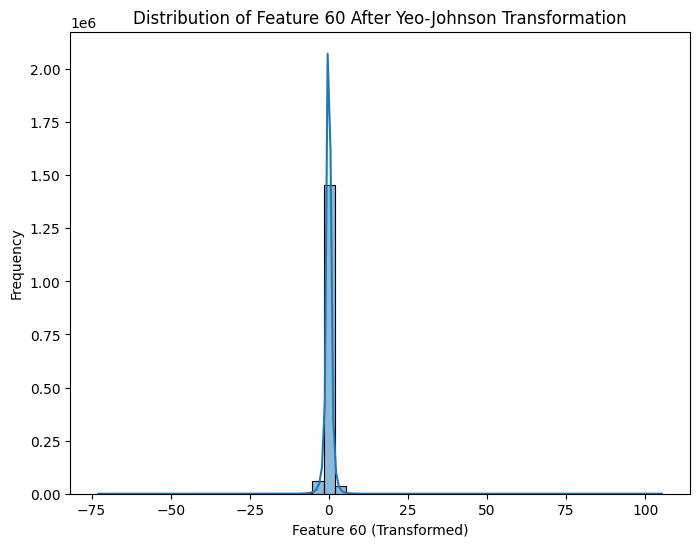

In [29]:
plt.figure(figsize=(8, 6))
sns.histplot(X_train["feature_60_transformed"], bins=50, kde=True)
plt.xlabel("Feature 60 (Transformed)")
plt.ylabel("Frequency")
plt.title("Distribution of Feature 60 After Yeo-Johnson Transformation")
plt.show()

In [31]:
from sklearn.preprocessing import PowerTransformer

# Initialize Yeo-Johnson Transformer for Feature 60
yeo_johnson = PowerTransformer(method='yeo-johnson')

# Apply transformation to Feature 60
X_train["feature_60_transformed"] = yeo_johnson.fit_transform(X_train[["feature_60"]])
X_test["feature_60_transformed"] = yeo_johnson.transform(X_test[["feature_60"]])

print("Yeo-Johnson transformation applied to Feature 60!")

# **Drop original features and use transformed versions**
X_train_transformed = X_train.drop(columns=["feature_60"]).copy()
X_test_transformed = X_test.drop(columns=["feature_60"]).copy()

# **Ensure transformed Feature 45 is used**
X_train_transformed["feature_45_log"] = X_train["feature_45_log"]
X_test_transformed["feature_45_log"] = X_test["feature_45_log"]

print(f"Final Training Shape: {X_train_transformed.shape}")
print(f"Final Testing Shape: {X_test_transformed.shape}")

# **Train LightGBM Model with Both Transformed Features**
lgb_model_45_60_transformed = lgb.LGBMRegressor(
    subsample=1.0,
    num_leaves=70,
    n_estimators=1000,
    min_child_samples=30,
    max_depth=15,
    learning_rate=0.3,
    random_state=42
)

print("Retraining the model with transformed Feature 45 & 60...")

lgb_model_45_60_transformed.fit(X_train_transformed, y_train)

print("Model retrained successfully!")

# **Predict on test set**
y_pred_45_60_transformed = lgb_model_45_60_transformed.predict(X_test_transformed)

# **Compute performance metrics**
mse_45_60_transformed = mean_squared_error(y_test, y_pred_45_60_transformed)
rmse_45_60_transformed = np.sqrt(mse_45_60_transformed)
mae_45_60_transformed = mean_absolute_error(y_test, y_pred_45_60_transformed)
r2_45_60_transformed = r2_score(y_test, y_pred_45_60_transformed)

# **Print evaluation results**
print(f"New Model with Transformed Feature 45 & 60 - Test MSE: {mse_45_60_transformed}")
print(f"New Model with Transformed Feature 45 & 60 - Test RMSE: {rmse_45_60_transformed}")
print(f"New Model with Transformed Feature 45 & 60 - Test MAE: {mae_45_60_transformed}")
print(f"New Model with Transformed Feature 45 & 60 - Test R²: {r2_45_60_transformed}")

Yeo-Johnson transformation applied to Feature 60!
Final Training Shape: (1555368, 56)
Final Testing Shape: (388842, 56)
Retraining the model with transformed Feature 45 & 60...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13143
[LightGBM] [Info] Number of data points in the train set: 1555368, number of used features: 56
[LightGBM] [Info] Start training from score 0.001706
Model retrained successfully!
New Model with Transformed Feature 45 & 60 - Test MSE: 0.3817250034108603
New Model with Transformed Feature 45 & 60 - Test RMSE: 0.6178389785460774
New Model with Transformed Feature 45 & 60 - Test MAE: 0.4318383930337163
New Model with Transformed Feature 45 & 60 - Test R²: 0.4973523714802963


In [38]:
# Model did not improve. Turning back to the model based on the transformed feature 45. 

import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Ensure we are only using the best transformation: feature_45_log
X_train_best = X_train.drop(columns=["feature_45"], errors="ignore").copy()
X_train_best["feature_45_log"] = X_train["feature_45_log"]

X_test_best = X_test.drop(columns=["feature_45"], errors="ignore").copy()
X_test_best["feature_45_log"] = X_test["feature_45_log"]

print(f"Final Training Shape: {X_train_best.shape}")
print(f"Final Testing Shape: {X_test_best.shape}")

# Train the LightGBM Model on the best version
lgb_model_best = lgb.LGBMRegressor(
    subsample=1.0,
    num_leaves=70,
    n_estimators=1000,
    min_child_samples=30,
    max_depth=15,
    learning_rate=0.3,
    random_state=42
)

print("Retraining LightGBM on the best model setup...")

lgb_model_best.fit(X_train_best, y_train)

print("Model successfully retrained!")

# Make predictions
y_pred_best = lgb_model_best.predict(X_test_best)

# Compute evaluation metrics
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

# Print the final performance
print(f"\n Final Best Model Performance:")
print(f"Test MSE: {mse_best}")
print(f"Test RMSE: {rmse_best}")
print(f"Test MAE: {mae_best}")
print(f"Test R²: {r2_best}")

Final Training Shape: (1555368, 57)
Final Testing Shape: (388842, 57)
Retraining LightGBM on the best model setup...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13398
[LightGBM] [Info] Number of data points in the train set: 1555368, number of used features: 57
[LightGBM] [Info] Start training from score 0.001706
Model successfully retrained!

 Final Best Model Performance:
Test MSE: 0.3796093510987368
Test RMSE: 0.6161244607209949
Test MAE: 0.43105947315401416
Test R²: 0.5001382189043817


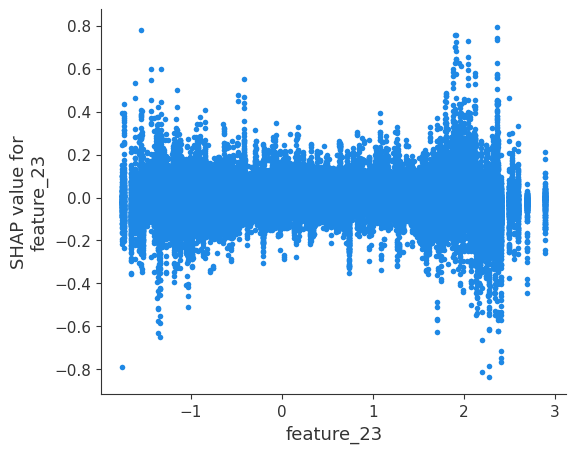

In [40]:
# Feature 23

import shap
import matplotlib.pyplot as plt

# Ensure SHAP values are calculated
explainer = shap.TreeExplainer(lgb_model_best)
shap_values = explainer.shap_values(X_test_best)

# Generate SHAP dependence plot for Feature 23
shap.dependence_plot("feature_23", shap_values, X_test_best, interaction_index=None)
plt.show()

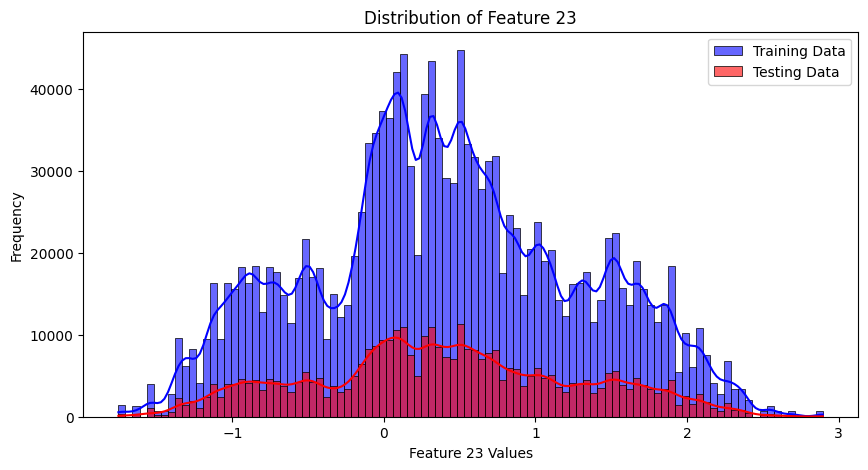

Training Data Statistics:
 count    1.555368e+06
mean     3.998244e-01
std      8.816127e-01
min     -1.752133e+00
25%     -1.518557e-01
50%      3.590539e-01
75%      1.010229e+00
max      2.896742e+00
Name: feature_23, dtype: float64

Testing Data Statistics:
 count    388842.000000
mean          0.395965
std           0.878852
min          -1.752133
25%          -0.152889
50%           0.355013
75%           1.007839
max           2.896742
Name: feature_23, dtype: float64

Negative Values in Training Data: 495462
Negative Values in Testing Data: 124308


In [41]:
# Distribution of feature 23

import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution for feature_23
plt.figure(figsize=(10, 5))
sns.histplot(X_train_best["feature_23"], bins=100, kde=True, color="blue", label="Training Data", alpha=0.6)
sns.histplot(X_test_best["feature_23"], bins=100, kde=True, color="red", label="Testing Data", alpha=0.6)
plt.xlabel("Feature 23 Values")
plt.ylabel("Frequency")
plt.title("Distribution of Feature 23")
plt.legend()
plt.show()

# Summary statistics
print("Training Data Statistics:\n", X_train_best["feature_23"].describe())
print("\nTesting Data Statistics:\n", X_test_best["feature_23"].describe())

# Count negative values
negative_count_train = (X_train_best["feature_23"] < 0).sum()
negative_count_test = (X_test_best["feature_23"] < 0).sum()

print(f"\nNegative Values in Training Data: {negative_count_train}")
print(f"Negative Values in Testing Data: {negative_count_test}")

In [42]:
# Polynominal feature transformation for feature 23

# Apply polynomial transformation
X_train["feature_23_squared"] = X_train["feature_23"] ** 2
X_test["feature_23_squared"] = X_test["feature_23"] ** 2

print("Polynomial transformation applied: feature_23_squared created!")

Polynomial transformation applied: feature_23_squared created!


In [43]:
# Create updated dataset
X_train_best = X_train.drop(columns=["feature_23"]).copy()
X_test_best = X_test.drop(columns=["feature_23"]).copy()

# Retain transformed feature 45 and new squared feature 23
X_train_best["feature_45_log"] = X_train["feature_45_log"]
X_test_best["feature_45_log"] = X_test["feature_45_log"]

X_train_best["feature_23_squared"] = X_train["feature_23_squared"]
X_test_best["feature_23_squared"] = X_test["feature_23_squared"]

print(f"Final Training Shape: {X_train_best.shape}")
print(f"Final Testing Shape: {X_test_best.shape}")

Final Training Shape: (1555368, 57)
Final Testing Shape: (388842, 57)


In [44]:
# Retrain LightGBM with both transformed features
lgb_model_best = lgb.LGBMRegressor(
    subsample=1.0,
    num_leaves=70,
    n_estimators=1000,
    min_child_samples=30,
    max_depth=15,
    learning_rate=0.3,
    random_state=42
)

print("Retraining LightGBM with transformed features: feature_45_log & feature_23_squared...")
lgb_model_best.fit(X_train_best, y_train)

print("Model successfully retrained!")

Retraining LightGBM with transformed features: feature_45_log & feature_23_squared...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13398
[LightGBM] [Info] Number of data points in the train set: 1555368, number of used features: 57
[LightGBM] [Info] Start training from score 0.001706
Model successfully retrained!


In [45]:
# Make predictions
y_pred_best = lgb_model_best.predict(X_test_best)

# Compute evaluation metrics
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

# Print results
print(f"Final Best Model Performance with Transformed Features:")
print(f"Test MSE: {mse_best}")
print(f"Test RMSE: {rmse_best}")
print(f"Test MAE: {mae_best}")
print(f"Test R²: {r2_best}")

Final Best Model Performance with Transformed Features:
Test MSE: 0.3802716077565697
Test RMSE: 0.6166616639264757
Test MAE: 0.4307309750505642
Test R²: 0.4992661729667127


In [ ]:
# transforming feature 23 did not change the r-squared

In [ ]:
# so far 3 features have been tried to transform. Apart from feature 45 this did not change or decreased the performance.